In [ ]:
import sys
import pickle
sys.path.insert(0, '/home/gridsan/sakshay/symmetry-mcts/')
from tree_node import Tree_node

In [3]:
tree_path = 'plotting_data/saved_tree/tree.pkl'

with open(tree_path, 'rb') as f:
    root = pickle.load(f)

In [4]:
# Best path
node = root
print(node.state, node.T/node.n)
while len(node.children) != 0:
    max_next = -100000
    index_max = -1
    curr_rewards = []
    for i, child in enumerate(node.children):
        curr_rew = child.T/child.n
        curr_rewards.append(curr_rew)
        if curr_rew > max_next:
            max_next = curr_rew
            index_max = i
    node = node.children[index_max]
    print(node.state, node.T/node.n)

{'smiles': 'c1([100He])c([101He])c2<pos2>c3c4c5n<pos0>nc5c6c7<pos2>c8c([101He])c([100He])<pos3>c8c7<pos1>c6c4<pos1>c3c2<pos3>1', 'fragments': {'pos0': [], 'pos1': [], 'pos2': [], 'pos3': [], 'pi_bridge': [], 'end_group': [], 'side_chain': [], 'terminate_pi_bridge': 0}, 'next_action': 'pos0'} -1.441488741649322
{'smiles': 'c1([100He])c([101He])c2<pos2>c3c4c5nsnc5c6c7<pos2>c8c([101He])c([100He])<pos3>c8c7<pos1>c6c4<pos1>c3c2<pos3>1', 'fragments': {'pos0': ['s'], 'pos1': [], 'pos2': [], 'pos3': [], 'pi_bridge': [], 'end_group': [], 'side_chain': [], 'terminate_pi_bridge': 0}, 'next_action': 'pos1'} -1.3480733284394397
{'smiles': 'c1([100He])c([101He])c2<pos2>c3c4c5nsnc5c6c7<pos2>c8c([101He])c([100He])<pos3>c8c7n([103He])c6c4n([103He])c3c2<pos3>1', 'fragments': {'pos0': ['s'], 'pos1': ['n([103He])'], 'pos2': [], 'pos3': [], 'pi_bridge': [], 'end_group': [], 'side_chain': [], 'terminate_pi_bridge': 0}, 'next_action': 'pos2'} -1.3316747256127883
{'smiles': 'c1([100He])c([101He])c2n([104He])c

In [6]:
import json
frag_val_map = {}

def traverse_tree(node):
    if node.children == [] and node.n != 0:
        state = node.state
        for key, val in state['fragments'].items():
            if isinstance(val, list):
                frag_val_map.setdefault(key, {})
                for identity in val:
                    frag_val_map[key].setdefault(identity, []).append(node.T / node.n)
    
    for child in node.children:
        traverse_tree(child)

traverse_tree(root)

with open('plotting_data/output_dir/frag_val_map.json', 'w') as out:
    json.dump(frag_val_map, out)

In [7]:
import json

frag_val_map = json.load(open('plotting_data/output_dir/frag_val_map.json', 'rb'))
pos_val = {}
for key, val in frag_val_map.items():
    concat_vals = []
    for _, ls in val.items():
        concat_vals = concat_vals + ls
    pos_val[key] = concat_vals

[1, 2, 3, 4, 5, 6, 7] ['pos0', 'pos1', 'pos2', 'pos3', 'pi_bridge', 'end_group', 'side_chain']


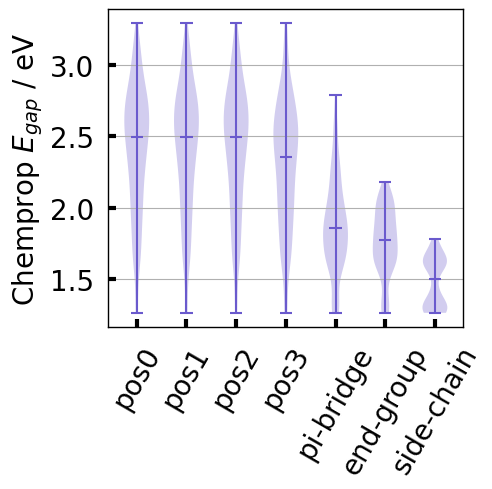

In [8]:
import matplotlib.pyplot as plt
import numpy as np
plt.rc('text')
plt.rc('font', family='sans-serif')
plt.rcParams["figure.figsize"]=[5,5]

fig, axs = plt.subplots(nrows=1, ncols=1)

# Fixing random state for reproducibility
np.random.seed(19680801)

# generate some random test data
all_data = [-1 * np.array(pos_val[key]) for key in ['pos0', 'pos1', 'pos2', 'pos3', 'pi_bridge', 'end_group', 'side_chain']]

# plot violin plot
vp = axs.violinplot(all_data,
                  showmeans=False,
                  showmedians=True)

# Set the colors of the violins
colors = ['slateblue'] * len(all_data)
for pc, color in zip(vp['bodies'], colors):
    pc.set_facecolor(color)

# Set the colors of the median line and the caps
for partname in ('cbars','cmins','cmaxes','cmedians'):
    vp[partname].set_edgecolor('slateblue')

axs.yaxis.grid(True)
print([y + 1 for y in range(len(all_data))], list(pos_val.keys()))
axs.set_xticks([y + 1 for y in range(len(all_data))],
                labels=['pos0', 'pos1', 'pos2', 'pos3', 'pi-bridge', 'end-group', 'side-chain'])
plt.xticks(rotation=60)

# Set the y-axis label
axs.set_ylabel('Chemprop $E_{gap}$ / eV', fontsize=20)

axs.spines['bottom'].set_linewidth(1)
axs.spines['top'].set_linewidth(1)
axs.spines['left'].set_linewidth(1)
axs.spines['right'].set_linewidth(1)

# axs.set_xlabel('Action type', fontsize=30)

# ax.set_ylabel('Bandgap', fontsize=30)

axs.tick_params(axis='y', length=6, width=3, labelsize=20, pad=10, direction='in')
axs.tick_params(axis='x', length=6, width=3, labelsize=20, pad=10, direction='in')
plt.tight_layout()
plt.savefig('plotting_data/output_dir/mcts_y6_violin.svg', dpi=400)
plt.savefig('plotting_data/output_dir/mcts_y6_violin.png', dpi=400)
plt.savefig('plotting_data/output_dir/mcts_y6_violin.pdf', dpi=400)

plt.show()

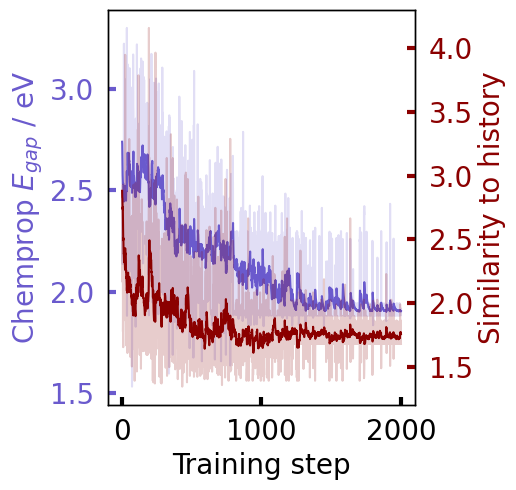

In [ ]:
import os, re
import pickle
import chemprop
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


plt.rc('text')
plt.rc('font', family='sans serif')
plt.rcParams["figure.figsize"]=[5,5]

num_iters = 2000

def smoothen(rewards, alpha):
    s_0 = rewards[0]
    smooth_rewards = [s_0]
    for rew in rewards[1:]:
        smooth_rewards.append(alpha * rew + (1-alpha) * smooth_rewards[-1])
    return np.array(smooth_rewards)

fig, ax = plt.subplots(1)
# bins = np.linspace(0.5, 4, 50)
best_smiles_df = pd.read_csv('plotting_data/generated_molecules/generations_iter_1.csv')
gap_rewards = best_smiles_df['gap_reward'][:num_iters]
sim_rewards = 6.5 * best_smiles_df['sim_reward'][:num_iters]

smooth_gaps = smoothen(gap_rewards, 0.1)
smooth_sims = smoothen(sim_rewards, 0.1)

iterations = np.arange(1, len(gap_rewards) + 1)[:num_iters]

ax.plot(iterations, gap_rewards, alpha=0.2, color='slateblue')
ax.plot(iterations, smooth_gaps, label='Chemprop $E_{rep}$ / eV'.replace('rep', 'GAP'), color='slateblue')

ax.set_ylabel('Chemprop $E_{gap}$ / eV', fontsize=20, color='slateblue')
ax.tick_params(axis='y',length=6,width=3,labelsize=20, pad=10, direction='in', colors='slateblue')

ax.spines['bottom'].set_linewidth(1)
ax.spines['top'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.spines['right'].set_linewidth(1)

ax.tick_params(axis='x',length=6,width=3,labelsize=20, pad=10, direction='in')

ax2 = ax.twinx()
ax2.plot(iterations, sim_rewards, alpha=0.2, color='darkred')
ax2.plot(iterations, smooth_sims, label='Similarity to history', color='darkred')
ax2.set_ylabel('Similarity to history', fontsize=20, color='darkred')
ax2.tick_params(axis='y',length=6,width=3,labelsize=20, pad=10, direction='in', colors='darkred')

ax2.spines['bottom'].set_linewidth(1)
ax2.spines['top'].set_linewidth(1)
ax2.spines['left'].set_linewidth(1)
ax2.spines['right'].set_linewidth(1)

ax2.tick_params(axis='x',length=6,width=3,labelsize=20, pad=10, direction='in')

ax.set_xlabel('Training step'.replace('rep', 'GAP'), fontsize=20)

plt.tight_layout()
plt.savefig('plotting_data/output_dir/mcts_y6_reward_sim_curve_single_run.svg', dpi=400)
plt.savefig('plotting_data/output_dir/mcts_y6_reward_sim_curve_single_run.png', dpi=400)
plt.savefig('plotting_data/output_dir/mcts_y6_reward_sim_curve_single_run.pdf', dpi=400)

plt.show()


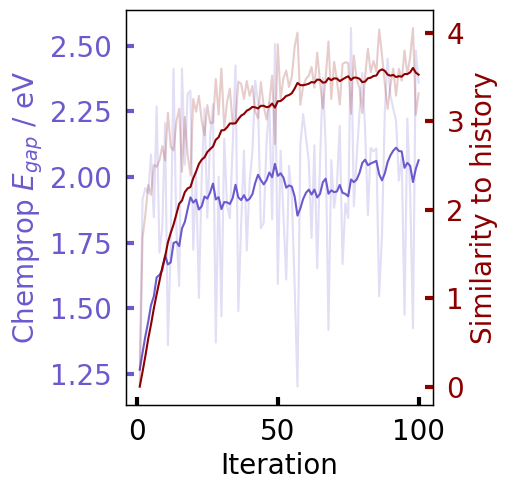

In [12]:
import os, re
import pickle
import chemprop
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rc('text')
plt.rc('font', family='sans serif')
plt.rcParams["figure.figsize"]=[5,5]

# root_dir = '/home/gridsan/sakshay/MCTS_paper_code/'

def smoothen(rewards, alpha):
    s_0 = rewards[0]
    smooth_rewards = [s_0]
    for rew in rewards[1:]:
        smooth_rewards.append(alpha * rew + (1-alpha) * smooth_rewards[-1])
    return np.array(smooth_rewards)

fig, ax = plt.subplots(1)
bins = np.linspace(0.5, 4, 50)
best_smiles_df = pd.read_csv('plotting_data/generated_molecules/best_smiles_iter_1.csv')
gap_rewards = best_smiles_df['gap_reward']
sim_rewards = 6.5 * best_smiles_df['sim_reward']

smooth_gaps = smoothen(gap_rewards, 0.1)
smooth_sims = smoothen(sim_rewards, 0.1)

iterations = np.arange(1, len(gap_rewards) + 1)

ax.plot(iterations, gap_rewards, alpha=0.2, color='slateblue')
ax.plot(iterations, smooth_gaps, label='Chemprop $E_{rep}$ / eV'.replace('rep', 'GAP'), color='slateblue')

ax.spines['bottom'].set_linewidth(1)
ax.spines['top'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.spines['right'].set_linewidth(1)

ax.tick_params(axis='y',length=6,width=3,labelsize=20, pad=10, direction='in', colors='slateblue')
ax.tick_params(axis='x',length=6,width=3,labelsize=20, pad=10, direction='in')

ax.set_xlabel('Iteration'.replace('rep', 'GAP'), fontsize=20)
ax.set_ylabel('Chemprop $E_{gap}$ / eV', fontsize=20, color='slateblue')

ax2 = ax.twinx()
ax2.plot(iterations, sim_rewards, alpha=0.2, color='darkred')
ax2.plot(iterations, smooth_sims, label='Similarity to history', color='darkred')
ax2.set_ylabel('Similarity to history', fontsize=20, color='darkred')
ax2.tick_params(axis='y',length=6,width=3,labelsize=20, pad=10, direction='in', colors='darkred')

plt.tight_layout()
plt.savefig('plotting_data/output_dir/mcts_y6_reward_sim_curve_diversity.svg', dpi=400)
plt.savefig('plotting_data/output_dir/mcts_y6_reward_sim_curve_diversity.png', dpi=400)
plt.savefig('plotting_data/output_dir/mcts_y6_reward_sim_curve_diversity.pdf', dpi=400)

plt.show()